In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

plt.style.use('ggplot')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)

### Task definition

For the short-term consumption/load forecasting case, we will try forecasting the energy consumption 2.5 days/60 hours ahead.

### Utils

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    # Note: Will throw error if there are any zeros in the target variable
    
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

In [3]:
def add_results(model_name, df_results, y_true, y_pred):
    
    # Ignore NaNs
    y_true_nonans = y_true[~y_pred.isna()]
    y_pred_nonans = y_pred[~y_pred.isna()]
    
    R2 = round(r2_score(y_true_nonans, y_pred_nonans), 3)
    MAE = round(mean_absolute_error(y_true_nonans, y_pred_nonans), 1)
    MAPE = str(round(mean_absolute_percentage_error(y_true_nonans, y_pred_nonans), 2)) + '%'
    
    df_results.loc[0 if pd.isnull(df_results.index.max()) else df_results.index.max() + 1] = [model_name, R2, MAE, MAPE]

In [4]:
def plot_predictions(y_test, y_pred, model_name, df_test, start: pd.Timestamp, end: pd.Timestamp, forecast_length: int=60):
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    start_idx = df_test[df_test['Datetime UTC+1'] == start].index[0]
    end_idx = df_test[df_test['Datetime UTC+1'] == end].index[0]
    
    ax.plot(df_test.loc[start_idx:end_idx, 'Datetime UTC+1'], y_test[start_idx:end_idx + 1], 'r', lw=2, label='Measured consumption')
    ax.plot(df_test.loc[start_idx:end_idx, 'Datetime UTC+1'], y_pred[start_idx:end_idx + 1], 'k--', lw=1.5, label='Forecasted consumption')
    
    forecast_interval_starts = [idx for idx in range(0, len(y_test) - forecast_length, forecast_length) \
                                 if idx in range(start_idx, end_idx + 1)]
    for i, idx in enumerate(forecast_interval_starts):
        if i == 0:
            label = 'Forecast interval start'
        else:
            label = None
        ax.axvline(df_test.loc[idx, 'Datetime UTC+1'], color='k', ls=':', lw=1.5, label=label)
    
    ax.set_title(model_name + ' forecast examples')
    ax.set_ylabel('MWh', rotation=0, fontsize=12)
    ax.yaxis.set_label_coords(-0.07, 0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    
    return fig

In [5]:
def stepwise_forecast_lr(model, x_test, forecast_length: int=60) -> pd.Series:
    
    y_pred = [np.nan] * len(x_test)
    
    for i in range(0, len(x_test) - forecast_length, forecast_length):
        for j in range(i, i + forecast_length):
            try:
                y_pred[j] = model.predict(x_test.loc[[j]])[0]
                if j != (i + forecast_length - 1):
                    x_test.at[j + 1, 'consumption_lag_1h'] = y_pred[j]
            except Exception as e:
                print(j)
                print(type(e).__name__ + ' occurred:', e)
                
    return pd.Series(y_pred)

### Load data

In [6]:
df_train = pd.read_csv('../../data/NordPool/merged_data/train_set.csv', parse_dates=['Datetime UTC+1'])
df_test = pd.read_csv('../../data/NordPool/merged_data/test_set.csv', parse_dates=['Datetime UTC+1'])

In [7]:
x_train = df_train[['Datetime UTC+1', 'NO5', 'temperature']]
y_train = df_train.NO5

x_test = df_test[['Datetime UTC+1', 'NO5', 'temperature']]
y_test = df_test.NO5

In [8]:
print('Number of 60 hour periods in test set:', len(y_test)/60)

Number of 60 hour periods in test set: 146.0


### Baseline models

In [9]:
# Dataframe for keeping track of results
df_results = pd.DataFrame(columns=['model', 'r2-score', 'mae', 'mape'])

heading_properties, cell_properties = [('font-size', '14px'), ('weight', 'bold')], [('font-size', '14px')]
dfstyle = [dict(selector="th", props=heading_properties), dict(selector="td", props=cell_properties)]

First, let's look at some baseline models that more advanced models can be compared against later.

#### Consumption one week ago

In [10]:
def naive_forecast_7d_ago(y_test: pd.Series) -> pd.Series:
    return y_test.shift(periods=7 * 24)

In [11]:
y_pred_naive_7d = naive_forecast_7d_ago(y_test)
add_results('naive_7d_ago', df_results, y_test, y_pred_naive_7d)

In [12]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,mae,mape
0,naive_7d_ago,0.772,134.1,7.82%


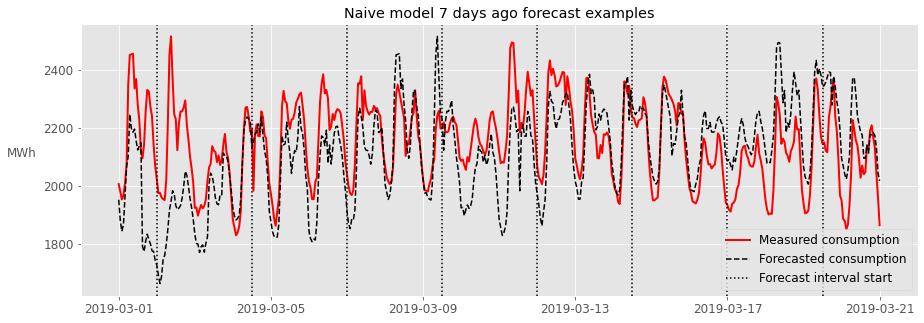

In [13]:
fig = plot_predictions(y_test, y_pred_naive_7d, 'Naive model 7 days ago', df_test, 
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [14]:
fig.savefig('../../plots/NordPool/modelling/naive_7d_ago_forecast_examples_1.png', bbox_inches='tight')

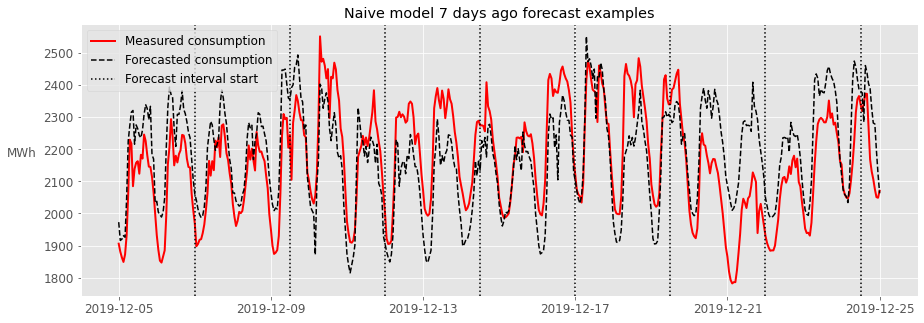

In [15]:
fig = plot_predictions(y_test, y_pred_naive_7d, 'Naive model 7 days ago', df_test, 
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [16]:
fig.savefig('../../plots/NordPool/modelling/naive_7d_ago_forecast_examples_2.png', bbox_inches='tight')

#### Mean consumption last 24 hours

In [17]:
def naive_forecast_24h_mean(y_test: pd.Series, n_forecast_hours: int = 60) -> pd.Series:
    
    y_pred = pd.Series([np.nan] * len(y_test))
    
    for i in range(0, len(y_test), n_forecast_hours):
        try:
            y_pred.loc[i:(i + n_forecast_hours)] = y_test.loc[(i - 25):(i - 1)].mean()
        except Exception as e:
            print(type(e).__name__ + ' occurred')
    
    return y_pred

In [18]:
y_pred_naive_24h_mean = naive_forecast_24h_mean(y_test)
add_results('naive_24h_mean', df_results, y_test, y_pred_naive_24h_mean)

In [19]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,mae,mape
0,naive_7d_ago,0.772,134.1,7.82%
1,naive_24h_mean,0.793,132.4,7.56%


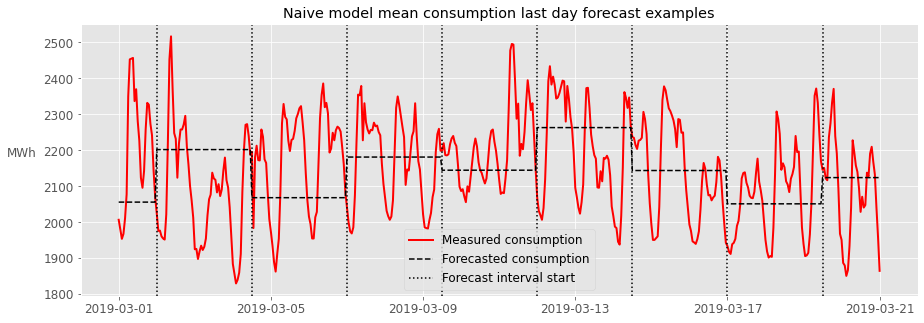

In [20]:
fig = plot_predictions(y_test, y_pred_naive_24h_mean, 'Naive model mean consumption last day', df_test,
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [21]:
fig.savefig('../../plots/NordPool/modelling/naive_24h_mean_forecast_examples_1.png', bbox_inches='tight')

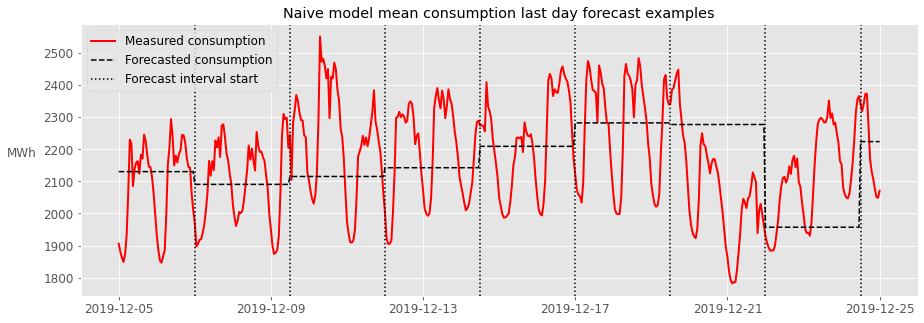

In [22]:
fig = plot_predictions(y_test, y_pred_naive_24h_mean, 'Naive model mean consumption last day', df_test, 
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [23]:
fig.savefig('../../plots/NordPool/modelling/naive_24h_mean_forecast_examples_2.png', bbox_inches='tight')

### Linear regression

In [24]:
def prep_features(df: pd.DataFrame) -> pd.DataFrame:  
    
    df = df.copy()
    
    # Add datetime features
    df['hour'] = df['Datetime UTC+1'].dt.hour
    df['month'] = df['Datetime UTC+1'].dt.month
    
    df['weekday'] = 0
    df.loc[df['Datetime UTC+1'].dt.weekday.isin([0, 1, 2, 3, 4]), 'weekday'] = 1
    
    df['saturday'], df['sunday'] = 0, 0
    df.loc[df['Datetime UTC+1'].dt.weekday == 5, 'saturday'] = 1
    df.loc[df['Datetime UTC+1'].dt.weekday == 6, 'sunday'] = 1

    # Add lag feature
    df.loc[:, 'consumption_lag_1h'] = df['NO5'].shift(1)
    
    # Add holiday feature
    nor_holidays = holidays.NO(years=range(2013, 2020))

    holiday_dict = dict()
    for date, holiday_name in nor_holidays.items():
        if holiday_name != 'Søndag': # Remove sundays (søndag)
            holiday_dict[date] = holiday_name

    df['holiday'] = 0
    df.loc[df['Datetime UTC+1'].dt.date.isin(holiday_dict.keys()), 'holiday'] = 1
    
    # Drop columns not needed
    df.drop(['Datetime UTC+1', 'NO5', 'temperature'], axis=1, inplace=True)
    
    return df

In [25]:
x_train_w_feats = prep_features(x_train)
x_test_w_feats = prep_features(x_test)

In [26]:
x_train_w_feats.head()

,hour,month,weekday,saturday,sunday,consumption_lag_1h,holiday
0,1,1,1,0,0,NaN,1
1,2,1,1,0,0,1927.0,1
2,3,1,1,0,0,1886.0,1
3,4,1,1,0,0,1894.0,1
4,5,1,1,0,0,1870.0,1


In [27]:
ohe = ColumnTransformer(
    [('ohe', OneHotEncoder(), ['hour', 'month'])],
    remainder='passthrough'
)

linear_regressor = linear_model.LinearRegression(fit_intercept=True, normalize=False)

estimator = Pipeline(
    [('ohe', ohe),
     ('imputer', SimpleImputer(strategy='median')),
     ('regressor', linear_regressor)]
)

In [28]:
estimator.fit(X=x_train_w_feats, y=y_train)

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['hour', 'month'])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('regressor', LinearRegression())])

In [29]:
y_pred_lr_stepwise = stepwise_forecast_lr(model=estimator, x_test=x_test_w_feats)
add_results('linear_regression', df_results, y_test, y_pred_lr_stepwise)

In [30]:
df_results.style.set_table_styles(dfstyle)

,model,r2-score,mae,mape
0,naive_7d_ago,0.772,134.1,7.82%
1,naive_24h_mean,0.793,132.4,7.56%
2,linear_regression_stepwise,0.86,102.5,6.09%


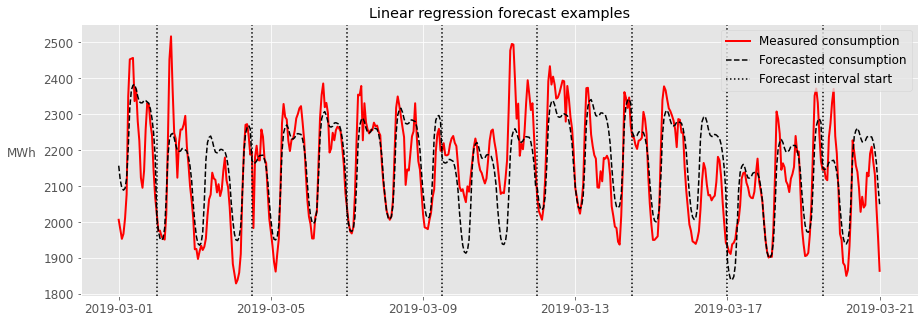

In [31]:
fig = plot_predictions(y_test, y_pred_lr_stepwise, 'Linear regression', df_test, 
                       start=pd.Timestamp('2019-03-01'), end=pd.Timestamp('2019-03-21'))

In [32]:
fig.savefig('../../plots/NordPool/modelling/linear_regression_forecast_examples_1.png', bbox_inches='tight')

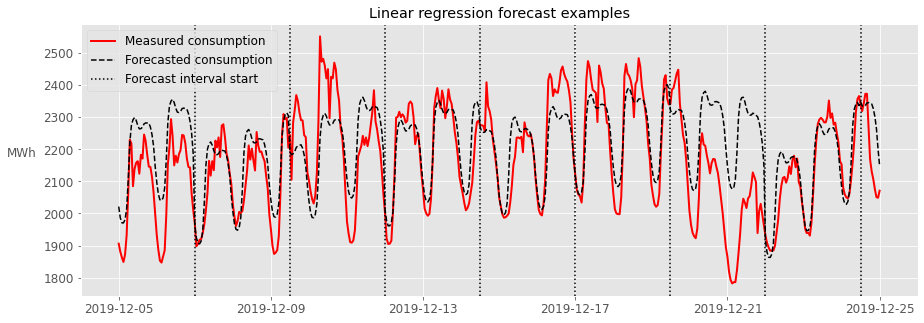

In [33]:
fig = plot_predictions(y_test, y_pred_lr_stepwise, 'Linear regression', df_test,
                       start=pd.Timestamp('2019-12-05'), end=pd.Timestamp('2019-12-25'))

In [34]:
fig.savefig('../../plots/NordPool/modelling/linear_regression_forecast_examples_2.png', bbox_inches='tight')